## Modul 1

In [1]:
import json
from os.path import normpath, dirname, abspath
import numpy as np
import pandas as pd
import xarray as xr
from lmfit import Model
import lmfit
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import natsort

In [2]:
# This will bind the paths from localSettings.json to objects in a class named paths
# usage: paths.<name>
class JSONObject:
    def __init__(self, dict):
        vars(self).update(dict)
with open(normpath(r"./localSettings.json"), "r") as f:
    path_data = f.read()
paths = json.loads(path_data, object_hook=JSONObject)

label_size = 22
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": 22,
        "legend.fontsize": 22,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        "lines.markersize": 10,
        "lines.linewidth": 2,
    }
)

# Default matplotlob colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

CONST_Velocity = 1.986

Load Kalibrierungsdaten

In [3]:
def Read_in_Data (path, dataarray_name_nc, dim3='volt'):
    # Look if we have a .nc file, if not open all the files, create DataArray and save it as .nc
    # NetCDF read in takes 2s, the normal one 40s
    NetCDF = False
    for file in os.listdir(path):
        if file.endswith(dataarray_name_nc):
            NetCDF = True

    if NetCDF:
        data_kalibrierung = xr.open_dataarray(normpath(path+dataarray_name_nc))
    else:
        # Absolute paths to files
        filenames = [normpath(path+files) for files in os.listdir(path)]
        filenames = natsort.natsorted(filenames)
        print('Make sure this is in order!!')
        print(filenames)
        # xarray handles multidimensional arrays easier
        data_kalibrierung = xr.concat(
            [xr.DataArray(
                np.loadtxt(files), 
                # like in a matrix, first dimension 'downwards', then to the 'right side'
                dims=('timestep', 'nr')) 
                for files in filenames],
            dim=(dim3)
        )
        data_kalibrierung.to_dataset(name='Default').to_netcdf(normpath(path+dataarray_name_nc))

    return data_kalibrierung

In [4]:
path = paths.Modul1+'Kalibrierung/'
dataarray_name_nc = 'data_kalibrierung.nc'
data_kalibrierung = Read_in_Data(path, dataarray_name_nc)
kali_mean_old = data_kalibrierung.mean(dim='timestep')
# Es geht einfacher
# Für data_kalibrierung sind die Hitzdrähte in der Reihenfolge 1,2,3,4,5,6 gespeichert
# Die Anordnung im Versuch von unten nach oben war aber 4,5,6,1,2,3
# data_kalibrierung = data_kalibrierung.roll(nr=3)
# Es soll aber in der Reihenfolge geplottet werden, dass "3" ganz oben und "4" ganz unten steht
# Reverse das ganze Dataframe an dieser Achse
# data_kalibrierung = data_kalibrierung.reindex(nr=data_kalibrierung.nr[::-1])
# Bisher nur die Bezeichnung (index) geändert, jetzt nochmal explizit sortieren
# data_kalibrierung = data_kalibrierung.sortby('nr')

kali_mean = data_kalibrierung.mean(dim='timestep')
kali_std = data_kalibrierung.std(dim='timestep')

Nr = range(1,8)
voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(kali_mean.min(dim=('volt', 'nr')), kali_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

Make sure this is in order!!
['G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_0.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_0.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_1.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_1.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_2.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_2.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_3.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_3.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_4.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_4.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung\\Kalibr_5.0V.txt']


Mean and Fit

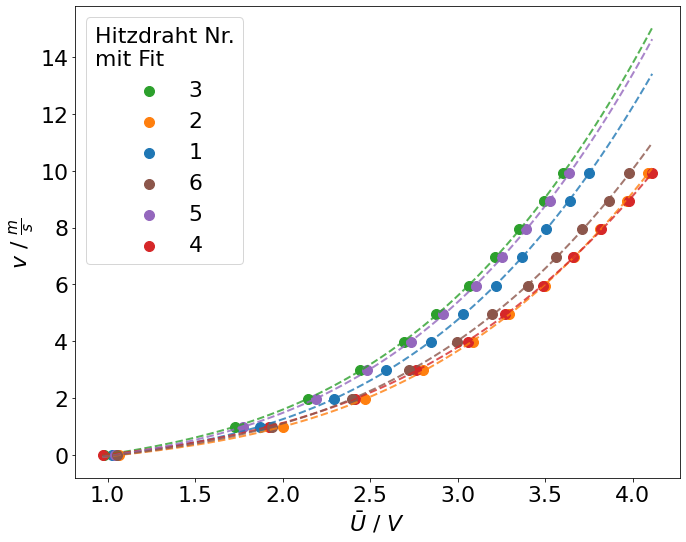

In [5]:
params_vec = list()
default_cycler = cycler(color=colors)
fig, ax = plt.subplots(1,1,figsize=(10,8), tight_layout=True)
for (hitzdraht, hitzdraht_std, i, sty) in zip(kali_mean.T, kali_std.T, Nr, default_cycler):
    ax.scatter(hitzdraht, velocity, label=f'{i}', **sty) 
    # ax.errorbar(hitzdraht, velocity, hitzdraht_std, label=f'{i}', fmt='o', fillstyle='none', markeredgewidth=2)

    # Fitting Polynomial 3rd degree
    model = lmfit.models.PolynomialModel(degree=3)
    params = model.guess(x=hitzdraht, data=velocity) 
    params_vec.append(params)
    result = model.fit(x=hitzdraht, data=velocity, params=params)
    ax.plot(hitzdraht_range,  result.eval(result.params, x=hitzdraht_range), ls='--', alpha=0.8, **sty) 

# print(result.fit_report())

ax.set_ylabel(r'$v$ / $\frac{m}{s}$')
ax.set_xlabel(r'$\bar{U}$ / $V$')
order = np.array([3,2,1,6,5,4])-1
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Hitzdraht Nr.\nmit Fit')
fig.savefig('Abb/Modul1/Kalibrierung.png')

Große Scheibe

Make sure this is in order!!
['G:\\Uni\\group 3\\Modul 1\\Gross\\g_0.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_1.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_1.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_2.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_2.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_3.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_3.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Gross\\g_4.0D.txt']


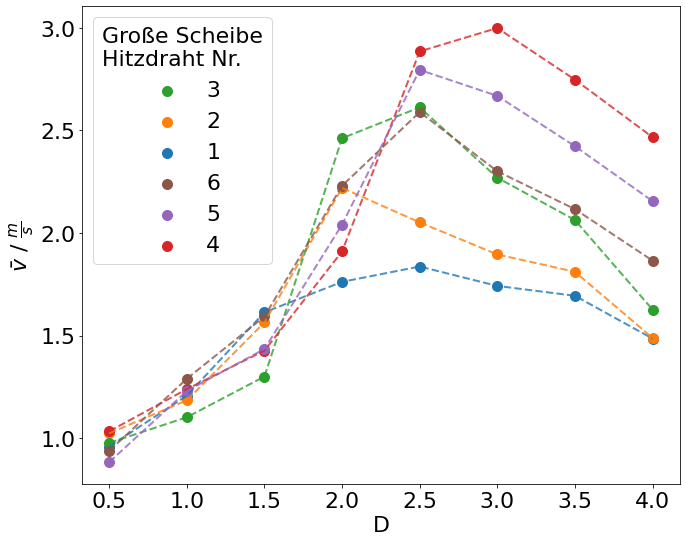

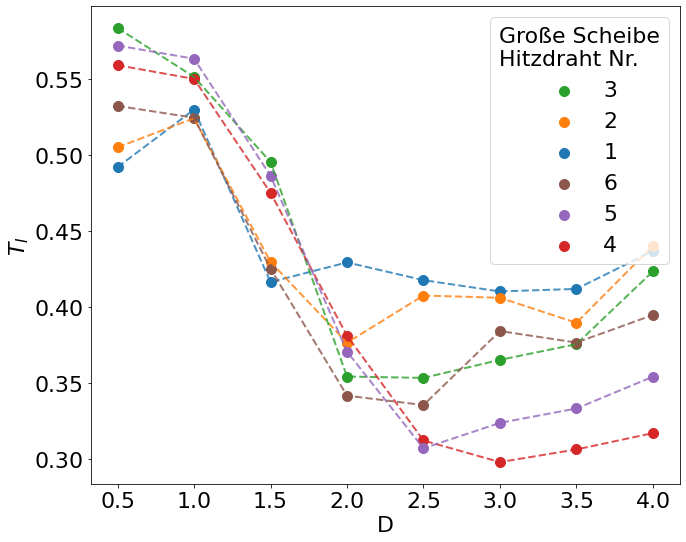

In [6]:
# Measurement at distance of multiple of Diameter 
D = np.arange(0.5,4.5,0.5)

path = paths.Modul1+'Gross/'
dataarray_name_nc = 'data_gross.nc'
data_gross = Read_in_Data(path, dataarray_name_nc, dim3='D')

fig_mean, ax_mean = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
idx = 0
for (hitzdraht, i, sty) in zip(data_gross.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Große Scheibe\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul1/Gross_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Große Scheibe\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul1/Gross_turb_int.png')

## Neue Kalibrierung für Mittel und Klein

In [7]:
path = paths.Modul1+'Kalibrierung ab Mittel/'
dataarray_name_nc = 'data_kalibrierung.nc'
data_kalibrierung = Read_in_Data(path, dataarray_name_nc)
# kali_mean_old = data_kalibrierung.mean(dim='timestep')

kali_mean = data_kalibrierung.mean(dim='timestep')
kali_std = data_kalibrierung.std(dim='timestep')

voltage = np.arange(0,5.5,0.5)
hitzdraht_range = np.linspace(kali_mean.min(dim=('volt', 'nr')), kali_mean.max(dim=('volt', 'nr')), 100)
velocity = voltage * CONST_Velocity

Make sure this is in order!!
['G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_0.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_0.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_1.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_1.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_2.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_2.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_3.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_3.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_4.0V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_4.5V.txt', 'G:\\Uni\\group 3\\Modul 1\\Kalibrierung ab Mittel\\m_Kalbr_5.0V.txt']


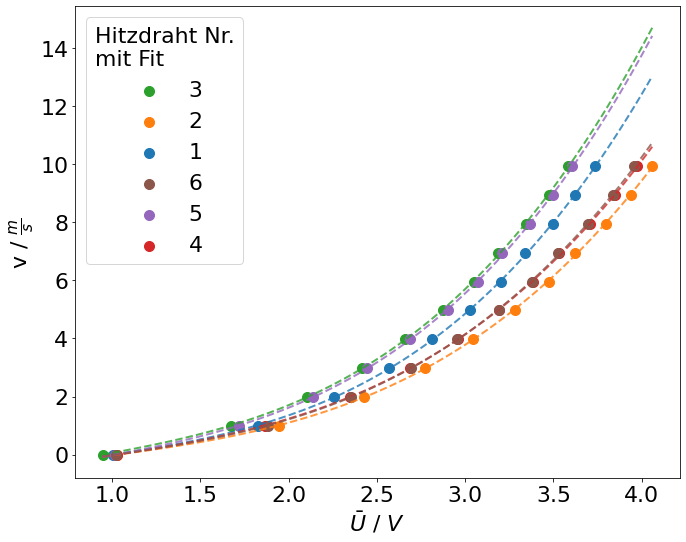

In [8]:
params_vec_m_k = list() # Mittel und Klein
default_cycler = cycler(color=colors)
fig, ax = plt.subplots(1,1,figsize=(10,8), tight_layout=True)
for (hitzdraht, hitzdraht_std, i, sty) in zip(kali_mean.T, kali_std.T, Nr, default_cycler):
    ax.scatter(hitzdraht, velocity, label=f'{i}', **sty) 
    # ax.errorbar(hitzdraht, velocity, hitzdraht_std, label=f'{i}', fmt='o', fillstyle='none', markeredgewidth=2)

    # Fitting Polynomial 3rd degree
    model = lmfit.models.PolynomialModel(degree=3)
    params = model.guess(x=hitzdraht, data=velocity) 
    params_vec_m_k.append(params)
    result = model.fit(x=hitzdraht, data=velocity, params=params)
    ax.plot(hitzdraht_range,  result.eval(result.params, x=hitzdraht_range), ls='--', alpha=0.8, **sty) 

# print(result.fit_report())

ax.set_ylabel(r'v / $\frac{m}{s}$')
ax.set_xlabel(r'$\bar{U}$ / $V$')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Hitzdraht Nr.\nmit Fit')
fig.savefig('Abb/Modul1/Kalibrierung_mittel_klein.png')

## Mittel

Make sure this is in order!!
['G:\\Uni\\group 3\\Modul 1\\Mittel\\m_0.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_1.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_1.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_2.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_2.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_3.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_3.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_4.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_4.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_5.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_5.5D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_6.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Mittel\\m_6.5D.txt']


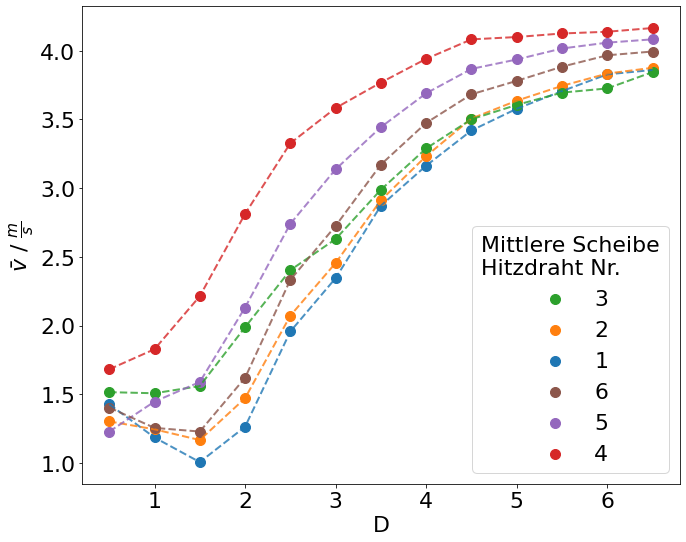

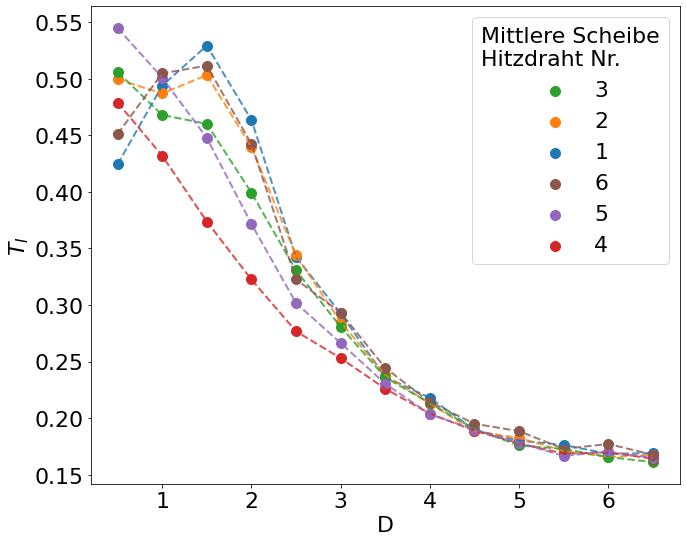

In [9]:
# Measurement at distance of multiple of Diameter 
D = np.arange(0.5,7.0,0.5)

path = paths.Modul1+'Mittel/'
dataarray_name_nc = 'data_mittel.nc'
data_mittel = Read_in_Data(path, dataarray_name_nc, dim3='D')

fig_mean, ax_mean = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
idx = 0
for (hitzdraht, i, sty) in zip(data_mittel.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec_m_k[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Mittlere Scheibe\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul1/Mittel_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Mittlere Scheibe\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul1/Mittel_turb_int.png')

## Klein

Make sure this is in order!!
['G:\\Uni\\group 3\\Modul 1\\Klein\\k_1.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_2.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_3.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_4.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_5.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_6.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_7.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_8.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_9.0D.txt', 'G:\\Uni\\group 3\\Modul 1\\Klein\\k_10.0D.txt']


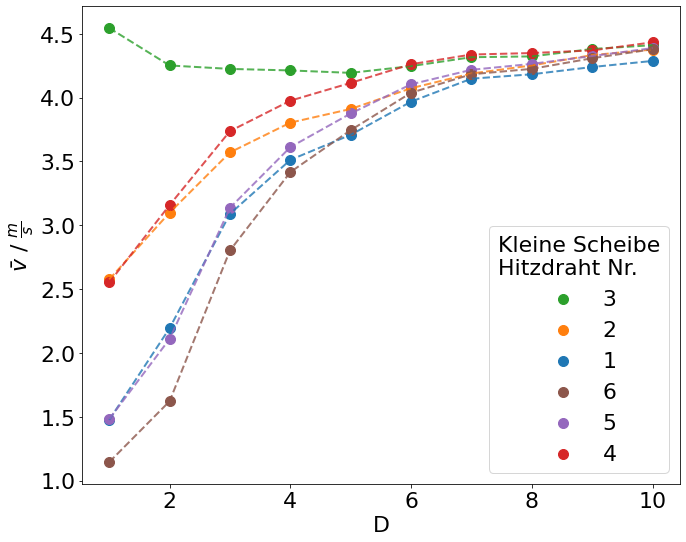

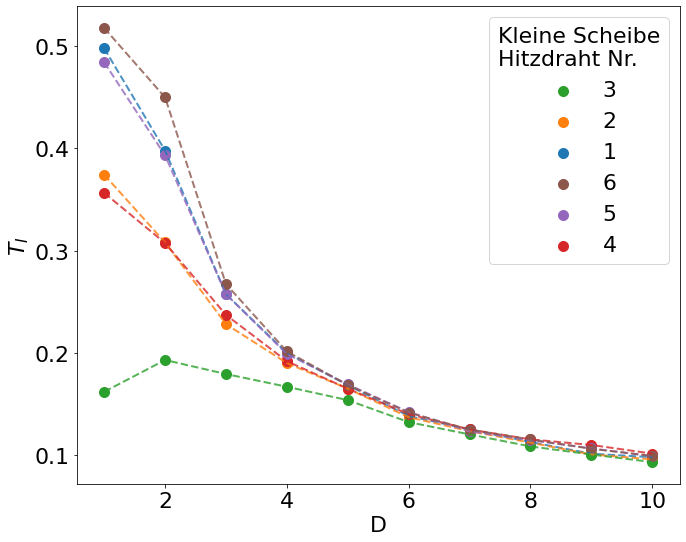

In [10]:
# Measurement at distance of multiple of Diameter 
D = np.arange(1,11,1)

path = paths.Modul1+'Klein/'
dataarray_name_nc = 'data_klein.nc'
data_klein = Read_in_Data(path, dataarray_name_nc, dim3='D')

fig_mean, ax_mean = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
fig_std, ax_std = plt.subplots(1,1, figsize=(10,8), tight_layout=True)
idx = 0
for (hitzdraht, i, sty) in zip(data_klein.T, Nr, default_cycler):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec_m_k[idx], x=hitzdraht),
        dims=('timestep','D')
    )
    # a2 = hitzdraht
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    # print(vel_mean)
    vel_std = hitzdraht_velocity.std(dim='timestep')
    
    ax_mean.scatter(D, vel_mean, label=f'{i}', **sty) 
    ax_mean.plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
    ax_std.scatter(D, vel_std/vel_mean, label=f'{i}', **sty)
    ax_std.plot(D, vel_std/vel_mean, alpha=0.8, ls='--', **sty) 
    idx += 1

ax_mean.set_xlabel('D')
ax_mean.set_ylabel(r'$\bar{v}$ / $\frac{m}{s}$')
handles, labels = ax_mean.get_legend_handles_labels()
ax_mean.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Kleine Scheibe\nHitzdraht Nr.')
fig_mean.savefig('Abb/Modul1/Klein_mean.png')

ax_std.set_xlabel('D')
ax_std.set_ylabel(r'$T_I$')
handles, labels = ax_std.get_legend_handles_labels()
ax_std.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Kleine Scheibe\nHitzdraht Nr.')
fig_std.savefig('Abb/Modul1/Klein_turb_int.png')

# Seiten vergleichen

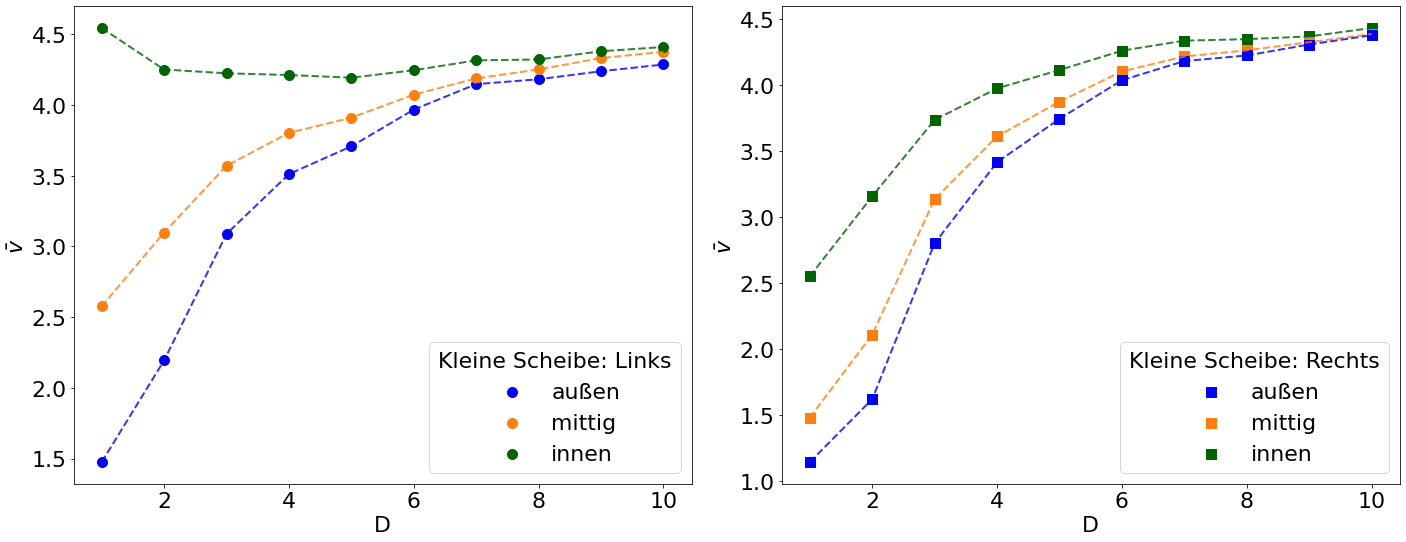

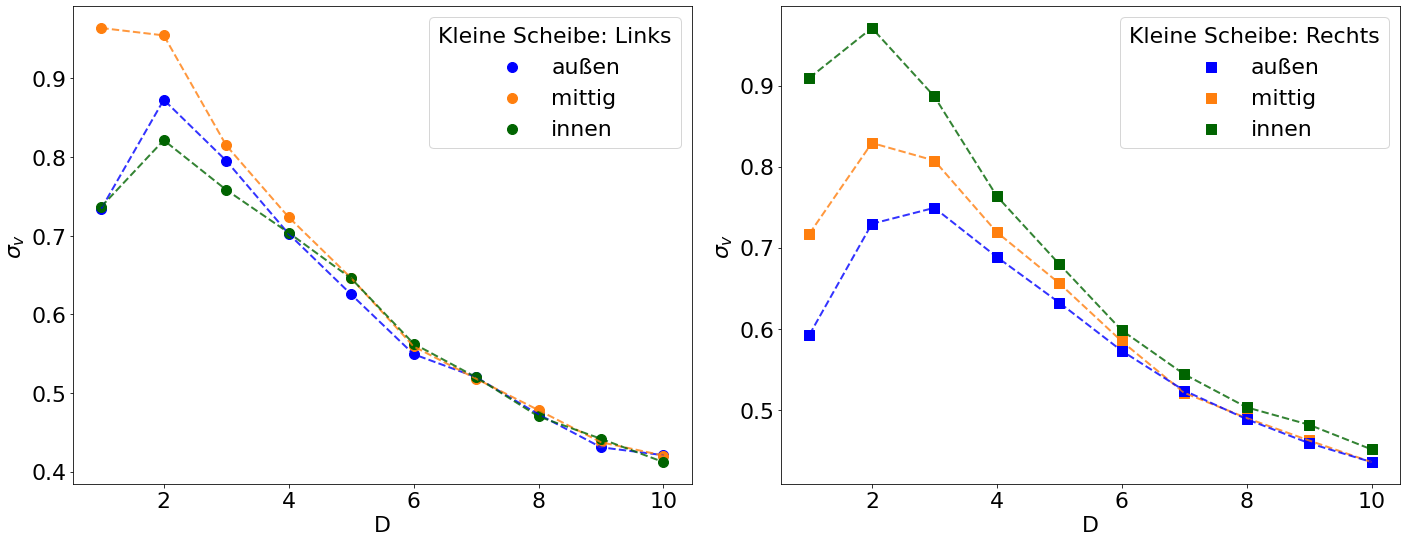

In [11]:
# D = np.arange(0.5,4.5,0.5)
# D = np.arange(0.5,7.0,0.5)
D = np.arange(1,11,1)
# new_cycler = cycler(color=['C0','C1','C2','C2','C1','C0'])
new_cycler = cycler(color=['b','tab:orange', 'darkgreen','darkgreen','tab:orange','b'])

label_vec = ['außen', 'mittig', 'innen', 'innen', 'mittig', 'außen']

fig_mean, ax_mean = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
fig_std, ax_std = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
idx = 0
for (hitzdraht, i, sty, lbl) in zip(data_klein.T, Nr, new_cycler, label_vec):
    # First we have to convert voltage to velocity and then take mean/std
    # You cannot interchange mean and non-linear calibration function with one another
    hitzdraht_velocity = xr.DataArray(
        model.eval(params_vec_m_k[idx], x=hitzdraht),
        dims=('timestep','D')
    )

    # Does this even make sense to compare it?
    # Normalize mean and std 
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    # vel_mean = (vel_mean-vel_mean.min(dim=('D'))) / vel_mean.max(dim=('D'))
    # vel_mean = vel_mean / vel_mean.max(dim=('D'))

    vel_std = hitzdraht_velocity.std(dim='timestep')
    # vel_std = (vel_std-vel_std.min(dim=('D'))) / vel_std.max(dim=('D'))
    # vel_std = vel_std / vel_std.max(dim=('D'))

    # Links in Windrichtung
    if i in [3,2,1]:
        ax_mean[0].scatter(D, vel_mean, label=lbl, **sty) 
        ax_mean[0].plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
        ax_std[0].scatter(D, vel_std, label=lbl, **sty)
        ax_std[0].plot(D, vel_std, alpha=0.8, ls='--', **sty) 
    # Rechts
    else:
        ax_mean[1].scatter(D, vel_mean, label=lbl, marker='s', **sty) 
        ax_mean[1].plot(D, vel_mean, alpha=0.8, ls='--', **sty) 
    
        ax_std[1].scatter(D, vel_std, label=lbl, marker='s', **sty)
        ax_std[1].plot(D, vel_std, alpha=0.8, ls='--', **sty) 
    idx += 1

for ax in ax_mean:
    ax.set_xlabel('D')
    ax.set_ylabel(r'$\bar{v}$')
    ax.legend(title='Kleine Scheibe: Links')

for ax in ax_std:
    ax.set_xlabel('D')
    ax.set_ylabel(r'$\sigma_v$')
    ax.legend(title='Kleine Scheibe: Links')

# You can change order in legend directly
order = [2,1,0]
handles, labels = ax_mean[1].get_legend_handles_labels()
ax_mean[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Kleine Scheibe: Rechts')

handles, labels = ax_std[1].get_legend_handles_labels()
ax_std[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Kleine Scheibe: Rechts')

fig_mean.savefig('Abb/Modul1/Klein_mean_links_rechts.png')
fig_std.savefig('Abb/Modul1/Klein_std_links_rechts.png')

In [12]:
int('2')

2

In [13]:
a = np.loadtxt(paths.Modul1+'Klein/k_2.0D.txt').T
a

array([[2.475169, 2.451813, 2.42418 , ..., 2.53208 , 2.520895, 2.562345],
       [2.814003, 2.761369, 2.682417, ..., 2.731433, 2.740973, 2.798871],
       [2.592281, 2.612019, 2.638994, ..., 2.783738, 2.797884, 2.795581],
       [2.777817, 2.773211, 2.781765, ..., 3.18672 , 3.132112, 2.903152],
       [2.375822, 2.372861, 2.327135, ..., 1.969221, 1.960668, 1.953431],
       [2.865979, 2.847228, 2.816964, ..., 2.217919, 2.191602, 2.164626]])

In [14]:
idx=0
for a_vec in a:
    out = model.eval(params_vec_m_k[idx], x=a_vec)
    if idx == 0:
        print(out[0:10])
    print(np.mean(out))
    idx += 1


[2.63143955 2.5541187  2.46475694 2.33291251 2.26396712 2.09091697
 1.94511288 1.79393414 1.62817064 1.53948654]
2.1937292486889017
3.0983924666624647
4.2511980778699545
3.1579080160732937
2.109393098439577
1.6214631184021628


In [15]:
a2 = data_klein[1]
a2[0:1,0:10]

<xarray.DataArray (timestep: 1, nr: 6)>
array([[2.475169, 2.814003, 2.592281, 2.777817, 2.375822, 2.865979]])
Dimensions without coordinates: timestep, nr

In [16]:
idx = 0
for a_vec in a2:
    hitzdraht_velocity = xr.DataArray(
            model.eval(params_vec_m_k[idx], x=a_vec),
            dims=('timestep')
        )
    if idx == 0:
        print(hitzdraht_velocity[0:10])
    vel_mean = hitzdraht_velocity.mean(dim='timestep')
    print(vel_mean.values)
    idx += 1

<xarray.DataArray (timestep: 6)>
array([2.63143955, 3.95292543, 3.04475682, 3.79283057, 2.3137812 ,
       4.19138572])
Dimensions without coordinates: timestep
3.321186550051511
2.57502295282583
3.8010932954383527
2.7325577299499257
3.582392066575957
2.654447522983394


IndexError: list index out of range

In [ ]:
count = 0 
for i in a:
    count += 1

print(count)

6


In [ ]:

count = 0 
for i in data_klein[0:0].T:
    count += 1

print(count)

6


In [ ]:
b = a[:,0:100]
b2 = np.array(a2[:,0:100])

In [ ]:
a2[0:100,:]

<xarray.DataArray 'Default' (timestep: 100, nr: 6)>
array([[2.77058 , 3.03112 , 2.670903, 3.066648, 2.797555, 3.027501],
       [2.791304, 3.030133, 2.676496, 3.076517, 2.804134, 3.016316],
       [2.80545 , 3.054476, 2.687023, 3.078491, 2.800516, 2.998881],
       ...,
       [2.804134, 3.076846, 2.663008, 3.062042, 2.541949, 2.820253],
       [2.806766, 3.083425, 2.676496, 3.080464, 2.532409, 2.814003],
       [2.803805, 3.084412, 2.682746, 3.110729, 2.531093, 2.807424]])
Dimensions without coordinates: timestep, nr